# Импорт и загрузка нужных библиотек

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
# from transformers import AutoProcessor, Blip2ForConditionalGeneration

%matplotlib inline

# Загрузка датасета

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Визуализация данных

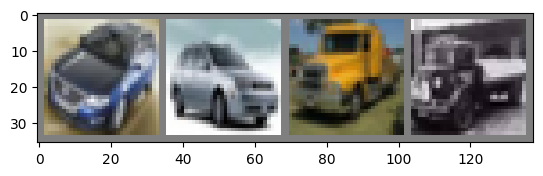

car   car   truck truck


In [3]:
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# CNN

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Model()

## Обучение

In [5]:
def training(count_epoch, criterion, optimizer):
    for epoch in range(count_epoch):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:    
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Training Completed')
    return model

## Тестирование

In [6]:
def testing(model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    imshow(torchvision.utils.make_grid(images))
    print('Target: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1



    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for the class: {classname} is {accuracy} %')

## Сравнение сетей с разными параметрами

- сеть № 1

[1,  2000] loss: 2.067
[1,  4000] loss: 1.879
[1,  6000] loss: 1.752
[1,  8000] loss: 1.685
[1, 10000] loss: 1.645
[1, 12000] loss: 1.606
[2,  2000] loss: 1.562
[2,  4000] loss: 1.539
[2,  6000] loss: 1.544
[2,  8000] loss: 1.509
[2, 10000] loss: 1.490
[2, 12000] loss: 1.478
[3,  2000] loss: 1.439
[3,  4000] loss: 1.446
[3,  6000] loss: 1.439
[3,  8000] loss: 1.403
[3, 10000] loss: 1.413
[3, 12000] loss: 1.408
[4,  2000] loss: 1.359
[4,  4000] loss: 1.364
[4,  6000] loss: 1.344
[4,  8000] loss: 1.363
[4, 10000] loss: 1.332
[4, 12000] loss: 1.337
Training Completed


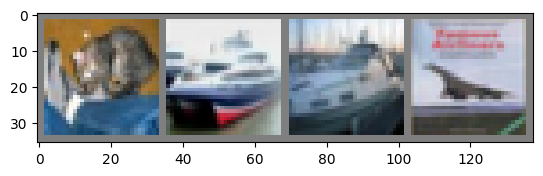

Target:  cat   ship  ship  plane
Predicted:  cat   car   car   ship 
Accuracy for the class: plane is 62.5 %
Accuracy for the class: car is 61.7 %
Accuracy for the class: bird is 29.3 %
Accuracy for the class: cat is 21.6 %
Accuracy for the class: deer is 42.5 %
Accuracy for the class: dog is 52.8 %
Accuracy for the class: frog is 77.4 %
Accuracy for the class: horse is 57.0 %
Accuracy for the class: ship is 61.5 %
Accuracy for the class: truck is 56.1 %


In [7]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.0001)
trained_model = training(4, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)

- сеть № 2

[1,  2000] loss: 1.858
[1,  4000] loss: 1.587
[1,  6000] loss: 1.493
[1,  8000] loss: 1.455
[1, 10000] loss: 1.442
[1, 12000] loss: 1.401
[2,  2000] loss: 1.317
[2,  4000] loss: 1.307
[2,  6000] loss: 1.278
[2,  8000] loss: 1.304
[2, 10000] loss: 1.258
[2, 12000] loss: 1.265
[3,  2000] loss: 1.211
[3,  4000] loss: 1.193
[3,  6000] loss: 1.189
[3,  8000] loss: 1.218
[3, 10000] loss: 1.194
[3, 12000] loss: 1.189
[4,  2000] loss: 1.103
[4,  4000] loss: 1.116
[4,  6000] loss: 1.125
[4,  8000] loss: 1.125
[4, 10000] loss: 1.132
[4, 12000] loss: 1.156
Training Completed


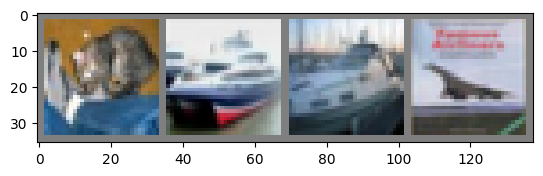

Target:  cat   ship  ship  plane
Predicted:  cat   car   ship  plane
Accuracy for the class: plane is 56.5 %
Accuracy for the class: car is 78.6 %
Accuracy for the class: bird is 55.6 %
Accuracy for the class: cat is 34.1 %
Accuracy for the class: deer is 42.6 %
Accuracy for the class: dog is 58.6 %
Accuracy for the class: frog is 72.5 %
Accuracy for the class: horse is 61.9 %
Accuracy for the class: ship is 78.6 %
Accuracy for the class: truck is 53.4 %


In [8]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.001)
trained_model = training(4, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)

[1,  2000] loss: 1.853
[1,  4000] loss: 1.586
[1,  6000] loss: 1.518
[1,  8000] loss: 1.485
[1, 10000] loss: 1.443
[1, 12000] loss: 1.403
[2,  2000] loss: 1.317
[2,  4000] loss: 1.311
[2,  6000] loss: 1.304
[2,  8000] loss: 1.292
[2, 10000] loss: 1.281
[2, 12000] loss: 1.256
[3,  2000] loss: 1.184
[3,  4000] loss: 1.209
[3,  6000] loss: 1.207
[3,  8000] loss: 1.175
[3, 10000] loss: 1.189
[3, 12000] loss: 1.179
[4,  2000] loss: 1.131
[4,  4000] loss: 1.090
[4,  6000] loss: 1.145
[4,  8000] loss: 1.126
[4, 10000] loss: 1.111
[4, 12000] loss: 1.113
[5,  2000] loss: 1.053
[5,  4000] loss: 1.076
[5,  6000] loss: 1.080
[5,  8000] loss: 1.087
[5, 10000] loss: 1.047
[5, 12000] loss: 1.073
[6,  2000] loss: 1.010
[6,  4000] loss: 1.038
[6,  6000] loss: 1.032
[6,  8000] loss: 1.035
[6, 10000] loss: 1.042
[6, 12000] loss: 1.019
[7,  2000] loss: 0.964
[7,  4000] loss: 0.998
[7,  6000] loss: 1.008
[7,  8000] loss: 1.006
[7, 10000] loss: 1.022
[7, 12000] loss: 1.016
[8,  2000] loss: 0.959
[8,  4000] 

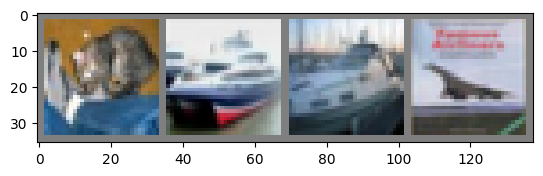

Target:  cat   ship  ship  plane
Predicted:  cat   ship  ship  ship 
Accuracy for the class: plane is 64.5 %
Accuracy for the class: car is 66.9 %
Accuracy for the class: bird is 45.5 %
Accuracy for the class: cat is 51.0 %
Accuracy for the class: deer is 42.8 %
Accuracy for the class: dog is 38.6 %
Accuracy for the class: frog is 75.8 %
Accuracy for the class: horse is 65.5 %
Accuracy for the class: ship is 75.8 %
Accuracy for the class: truck is 79.6 %


In [9]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.001)
trained_model = training(8, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)